In [1]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt
import time
import scipy.stats
import pandas as pd

In [2]:
Vout = np.array([3.2, 3.3, 3.4])
LS_Ron = np.array([6.3, 8.3, 11])*1e-3
Iout = np.array([2.64, 3.03, 3.45])
Vin = np.array([13.3, 13.35, 13.37])
#HS_Tsw = 5.17*1e-9
Fsw = np.array([430, 455, 489])*1e3
Vbody_diode = np.array([0.65, 0.8, 1.2])
#LS_QRR = 120*1e-9
#DT = 20*1e-9
L = np.array([5.4, 4.5, 3.6])*1e-6
DCR = np.array([12.61, 19, 27.23])*1e-3
#ESR_Cin = 4.23*1e-3
P_IC = np.array([83.93, 88.81, 93.69])*1e-3

In [3]:
from PSU_class import PSU

model = PSU(Vout, LS_Ron, Iout, Vin, Fsw, Vbody_diode, L, DCR, P_IC)
model.P_in()

array([ 9.28592306, 10.85749529, 12.66975792])

In [4]:
model.I_in()

array([0.6981897 , 0.81329553, 0.94762587])

In [5]:
a = model.I_in()
a.shape

(3,)

In [6]:
def randomize(tolerance, dist="Nominal", cpk = 1.67):
    """
    Function that returns a value within specified margins given component properties.
    Input:
       - Tolerance: Numpy Array. Properties of the electronic component. Array with shape = (3,).
       - dist: String. Statistical distribution from which to sample.
         * Uni: samples a value from a uniform distribution.
         * Gauss: samples a value from a Gaussian distribution.
         * Nominal: returns the nominal value.
       - cpk: Float. Process capability required for the component.
    Output:
       - Float. Sampled from distribution.
    """
    if dist == "Uni":
        return random.uniform(tolerance[0], tolerance[2])
    elif dist == "Gauss":
        mu = tolerance[1]
        sigma = (tolerance[2]-tolerance[0])/(6 * cpk)
        return random.gauss(mu, sigma)
    else:
        return tolerance[1]
    

In [7]:
def simulation(n_points, base_model, base_class, dist):#, sens_var, sens_dist):
    """
    Function that simulates observations for bla bla. 
    Input:
    - n_points : number of points simulated
    - dist_components: distributon assumed for the components
    """
    y = np.zeros(n_points)
    for i in range(n_points):
        
        # Randomize numbers
        Vout_r = randomize(base_model.Vout, dist)
        LS_Ron_r = randomize(base_model.LS_Ron, dist)
        Iout_r = randomize(base_model.Iout, dist)
        Vin_r = randomize(base_model.Vin, dist)
        Fsw_r = randomize(base_model.Fsw, dist)
        Vbody_diode_r = randomize(base_model.Vbody_diode, dist)
        L_r = randomize(base_model.L, dist)
        DCR_r = randomize(base_model.DCR, dist)
        P_IC_r = randomize(base_model.P_IC, dist)
        
        #Sensible Analysis
        # modify one value to plug into the class
        # "sens_var" = randomize(base_model."sens_var", sens_dist)

        sim_PSU = base_class(Vout_r, LS_Ron_r, Iout_r, Vin_r, Fsw_r, Vbody_diode_r, L_r, DCR_r, P_IC_r)
        
        y[i] = sim_PSU.P_in()
    return y

In [8]:
test_array = simulation(100000, model, PSU, "Uni")
test_array

array([ 9.75095521, 10.157152  , 10.01961718, ..., 11.89767156,
       11.31373822, 11.19420268])

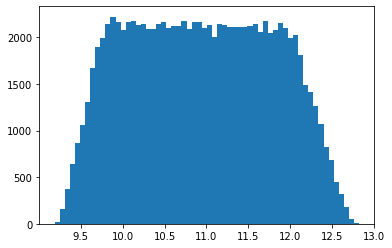

In [9]:
plt.hist(test_array, bins = 'auto')
plt.show()

### Chi-Square

In [10]:
from sklearn.preprocessing import StandardScaler

def standarise(y,pct,pct_lower):
    sc = StandardScaler() 
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

In [39]:
# github.com/samread81/Distribution-Fitting-Used_Car_Dataset/blob/master/Workbook.ipynb
def fit_distribution(data_raw, distribution):
    data = normalize_data(data_raw)
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(data)
    return dist, param

def compute_chi_square(data):
    #size = len(data)
    #data = normalize_data(data_raw)
    y,size,_ = standarise(data, 0.99, 0.01)
    dist_names = ['weibull_min', 'norm', 'weibull_max', 'beta', 'invgauss',
                  'uniform', 'gamma', 'expon', 'lognorm', 'pearson3', 'triang']
    
    chi_square_statistics = []
    #log_likelihood = []
    
    # Bins
    percentile_bins = np.linspace(0,100, 11)
    percentile_cutoffs = np.percentile(y, percentile_bins)
    obs_frequency, _ = np.histogram(y, bins=percentile_cutoffs)
    cum_obs_frequency = np.cumsum(obs_frequency)
    
    # Check candidate distributions
    for distribution in dist_names:
        # Set up candidate distribution
        
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y)
        #log_likelihood.append(np.sum(np.log(dist.pdf(y, *param))))
        print('Distribution: ' + distribution + ' || Parameters: ' + str(param))# + '|| Log-likelihood: ' + 
              #str(log_likelihood) + '\n')
        
        # CDF
        cdf_fit = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fit[bin+1] - cdf_fit[bin]
            expected_frequency.append(expected_cdf_area)
        
        # Chi-Square
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_obs_frequency) ** 2) / cum_obs_frequency), 0)
        chi_square_statistics.append(ss)
    
    # Sort
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    #results['Log_likelihood'] = log_likelihood
    results['Chi_square'] = chi_square_statistics
    results.sort_values(['Chi_square'], inplace=True)
    
    print('\nDistributions listed by Goodness of Fit:')
    print('..........................................')
    print(results)   
    

In [38]:
compute_chi_square(test_array)

Distribution: weibull_min || Parameters: (2.352309805050946, -2.1786822243815047, 2.46173982816978)
Distribution: norm || Parameters: (-5.122868116108738e-15, 1.0)
Distribution: weibull_max || Parameters: (2.642089337418037, 2.397585329365225, 2.7039571969279335)
Distribution: beta || Parameters: (1.2927122608030845, 1.3486828145472973, -1.8537277968459587, 3.786926071181491)
Distribution: invgauss || Parameters: (0.02857865556256814, -6.084352233165063, 212.72159963441953)
Distribution: uniform || Parameters: (-1.8534677375273925, 3.7857764443401765)
Distribution: gamma || Parameters: (5292.130804394257, -72.73372186879939, 0.013743708053652211)
Distribution: expon || Parameters: (-1.8534677375273925, 1.8534677375273874)
Distribution: lognorm || Parameters: (0.03205457425163377, -31.190351181476217, 31.173901327334292)
Distribution: pearson3 || Parameters: (0.17329195346192117, -6.9573659412747854e-15, 1.0021294690901978)
Distribution: triang || Parameters: (0.3785590045004925, -2.086

In [41]:
Q = 2*(-130462.598300 + 128071.407941)

for i in range(1000):
    



-4782.380718

## Choose Model

### Non-Nested Likelihood Ratio Test

In [22]:
### Computations of the test
from scipy.stats import norm

data = [1,2,3,4,5]
m,s = norm.fit(data)
log_likelihood = np.log(np.product(norm.pdf(data,m,s)))
log_likelihood

-8.827560617423226

In [28]:
dist = getattr(scipy.stats, 'weibull_min')
param = dist.fit(data)
log_likelihood = np.sum(np.log(dist.pdf(data, *param))) #MAKE THIS WORK! 
print('Distribution: ' + 'distribution' + ' || Parameters: ' + str(param) + '|| Log-likelihood: ' + str(log_likelihood) + '\n')

Distribution: distribution || Parameters: (0.6165858976514229, 0.9999999999999999, 1.2856205153053542)|| Log-likelihood: 3.8051854863032792



### Q-Q Plot

In [ ]:
y_std,_,_ = standarise(test_array, 0.99, 0.01)

data_points = scipy.stats.beta.rvs(1.845363833710495, 1.9930181654900756, 9.193002210521788, 3.6222049153761584, size=2000)   
data_points2 = scipy.stats.weibull_min.rvs(2.502664460995821, 9.006142851433948, 2.180353831209773,size = 2000) 

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 2], [9, 13], ls="--", c=".3")

percentile_bins = np.linspace(0,100,51)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)
percentile_cutoffs_expon= np.percentile(data_points, percentile_bins)


percentile_cutoffs_invgauss = np.percentile(data_points2, percentile_bins)


ax.scatter(percentile_cutoffs1,percentile_cutoffs_invgauss,c='orange',label = 'Weibull Min distribution',s = 40)
ax.scatter(percentile_cutoffs1,percentile_cutoffs_expon,c='blue',label = 'Exponential Distribution',s = 40)


ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
a = scipy.stats.beta.pdf(test_array,1.845363833710495, 1.9930181654900756, 9.193002210521788, 3.6222049153761584)

In [ ]:
sns.distplot(a = test_array, kde = False, norm_hist=True)
sns.kdeplot(data = test_array, shade= False)

In [ ]:
sns.distplot(a = test_array, kde = False, norm_hist=True)
plt.plot(test_array, scipy.stats.beta.pdf(test_array,1.845363833710495, 1.9930181654900756, 9.193002210521788, 3.6222049153761584))

### Kolmogorov-Smirnoff 2 Sample Test

In [ ]:
from scipy.stats import ks_2samp

In [ ]:
data1 = np.random.choice(a = test_array, size = 2000)
data2 = data_points
test = ks_2samp(data1,data2)
print(test)

In [ ]:
test_statistic = 0.034

In [ ]:
n1 = 30
n2 = 30
alpha = 0.05
c_alpha = 1.36 # Make a dict mapping c values to alpha
critical_value = c_alpha * ((n1 + n2)/(n1*n2))**0.5 
critical_value

In [ ]:
,if test_statistic > critical_value:
    print('The two samples come from different distributions')
else:
    print('The two samples come from same distributions')